# Foundations of CSS Final Group Project: *Question Goes Here*

TODO: Add link to research poster and report

## Prerequisits

### Install Dependencies

In [ ]:
# ATTENTION: pycaret needs PYTHON VERSION 3.11. OR LOWER
!pip install pyreadstat pandas numpy matplotlib wbgapi pycaret scipy

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import shutil
import re
import wbgapi as wb
import pycaret as pc
import scipy as sp

### Load and Prepare Data

#### Attitudes Data

You need to download this data from: https://www.worldvaluessurvey.org/WVSDocumentationWVL.jsp

The results are very similar to the other notebook, so I wouldn't bother.

In [ ]:
survey_data_raw_df = pd.read_csv("data/WVS_Time_Series_1981-2022_csv_v5_0.csv")

There are 145 columns in the dataset.
In the following, we make a selection of relevant ones
and additionally group certain questions into
"support for public" vs "support for individual" action.

In [7]:
# Define mapping functions to support getting survey data in usable format

def extract_integer(x):
    if (type(x) == int): return x
    if (type(x) == float): return int(x)

    return int(x.split('.')[0]) # assuming format like 2. agree somewhat

# The below functions are helpers to make mapping the liker-scale responses (1.-5. (agree or disagree) or 1-4).
# The responses are stretched to values between -2 and 2.
# See in the next cell how it's used.
def likert_scale_to_float(input, invert: bool, shift: float):
    int_val = extract_integer(input)
    if int_val < 0:
        return np.nan;
    else:
        return float(int_val) + shift if invert == False else (float(int_val) + shift) * -1

def likert_scale_to_float_5(input):
    val = likert_scale_to_float(input, invert=False, shift=-3)
    return val if val >= -2 and val <= 2 else np.nan

def likert_scale_to_float_invert_5(input):
    val = likert_scale_to_float(input, invert=False, shift=-3)
    return val if val >= -2 and val <= 2 else np.nan

def likert_scale_to_float_invert_4(input, shift=-2.5):
    val = likert_scale_to_float(input, invert=True, shift=shift) * 4/3
    return val if val >= -2 and val <= 2 else np.nan

def likert_scale_to_float_4(input, invert=False):
    val = likert_scale_to_float(input, invert, shift=-2.5) * 4/3
    return val if val >= -2 and val <= 2 else np.nan



In [111]:
# Comments beginning with letters (abcd) indicate which study have the question, if not all (1993, 2000, 2010, 2020).
# Some mapping comments contain the exact question asked in the survey.
# Detailed explanation of variables can be found here: https://search.gesis.org/research_data/ZA8793#variables|exploredata-ZA8793_VarWRKHRS|0|variable_order|asc

# The below mapping is used to rename the original column names
# and define functions to convert the columns, if necessary.
# Not all of the dataset's questions are mapped (and kept).
# Those are all that seemed vaguely interesting
# but for the main analysis we only consider a subset.
mapping = {
  "S008": {     "name": 'id',
                "mapper": int },
  "S020": {     "name": 'year',
                "mapper": extract_integer },
  "COUNTRY_ALPHA": {     "name": 'country_iso3',
                "mapper": None },
  "X003": {     "name": 'age',
                "mapper": extract_integer },
  "X001": {     "name": 'sex',
                "mapper": None },
  "X023R":{     "name": 'education_time',
                "mapper": lambda val: val if val >= 0 else np.nan },
  "B021": {     "name": 'global_warming_serious',
                "mapper": likert_scale_to_float_invert_4 },
  "B022": {     "name": 'biodiv_loss_serious',
                "mapper": likert_scale_to_float_invert_4 },
}


column_naming_map = { key: value["name"] for key, value in mapping.items() }

survey_df = survey_data_raw_df[list(column_naming_map.keys())].rename(columns=column_naming_map)

# For some columns, we need to convert responses e.g. '1. Strongly disagree' might become -2
# The conversion functions are defined in the mapping dict above.
for mapping_key in mapping.keys():
  new_key = mapping[mapping_key]["name"]
  mapping_fn = mapping[mapping_key]["mapper"]
  if mapping_fn:
    survey_df[new_key] = survey_df[new_key].map(mapping_fn)



In [112]:
# Ignore data where global warming or biodiv serious question have no responses
survey_df = survey_df[survey_df['biodiv_loss_serious'].notna() & survey_df['global_warming_serious'].notna()]

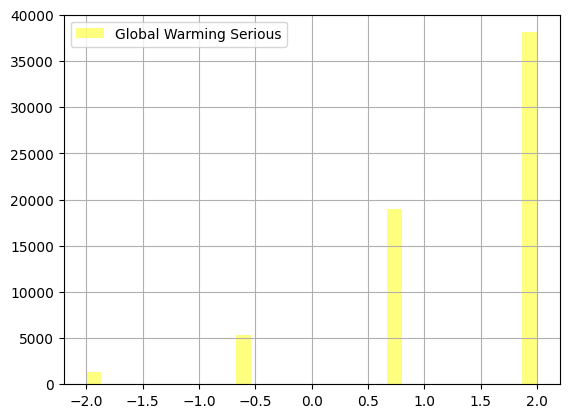

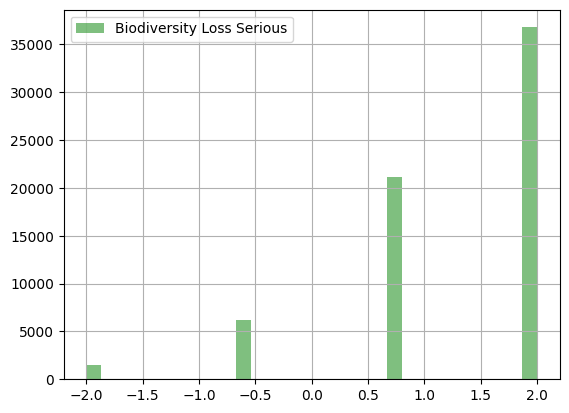

In [58]:
# survey_df['score_individual_action'].hist(bins=30, label="Focus: Individual Action", alpha=0.4, color="red")
# survey_df['score_collective_action'].hist(bins=30, label="Focus: Collective Action", alpha=0.4, color="blue")
# plt.legend()
# plt.show()
survey_df['global_warming_serious'].hist(bins=30, label="Global Warming Serious", alpha=0.5, color="yellow")
plt.legend()
plt.show()
survey_df['biodiv_loss_serious'].hist(bins=30, label="Biodiversity Loss Serious", alpha=0.5, color="green")
plt.legend()
plt.show()

#### Fossil dependence data (Fossil Rent as Fraction of GDP)

In [114]:
fuel_rents_wb_indicators = [
  'NY.GDP.NGAS.RT.ZS', # Rent from Gas as Percentage of GDP
  'NY.GDP.COAL.RT.ZS', # Rent from Coal as Percentage of GDP
  'NY.GDP.PETR.RT.ZS', # Rent from Petroleum as Percentage of GDP
]
gdp_us_current_wb_indicator = 'NY.GDP.PCAP.CD' # GDP per Capita by Current US$

# Fetch data from world bank (Fossil Rents and GDP data)
fossil_dependence_df = wb.data.DataFrame(
  fuel_rents_wb_indicators + [gdp_us_current_wb_indicator],
  economy=survey_df['country_iso3'].unique(), 
  time=survey_df['year'].unique(),
  numericTimeKeys=True,
  skipBlanks=True,
  columns='series'

).reset_index()


# Rents are in percent form. Normalize to [0-1]
fossil_dependence_df[fuel_rents_wb_indicators] /= 100
# Sum fossil rent indicators (fraction Fossil Rent of total GDP)
fossil_dependence_df['fossil_rent'] = fossil_dependence_df[['NY.GDP.NGAS.RT.ZS', 'NY.GDP.COAL.RT.ZS', 'NY.GDP.PETR.RT.ZS']].sum(axis=1)

# Log GDP per Capita to reduce skew, as done in Knight (2018)
fossil_dependence_df['gdp_logged'] = np.log(fossil_dependence_df[gdp_us_current_wb_indicator])

### Merge Datasets

In [115]:
# Add iso2 country codes to wb data
# fossil_dependence_df = pd.DataFrame.merge(fossil_dependence_df, country_code_df, left_on='economy', right_on='country_iso3')

# merge survey and wb data by time and country (for a year and country, each respondent gets the same fossil dependence scores)
merged_df = pd.DataFrame.merge(fossil_dependence_df, survey_df, left_on=['time', "economy"], right_on=['year', 'country_iso3'])

# Since the dataset is quite big and needs to be downloaded, you can use the following compilation instead.
# merged_df = pd.read_csv('wvc_merged.csv')

## Analysis

### Identify Awareness, Public, and Collective Action variables

In [117]:
all_params = ['NY.GDP.COAL.RT.ZS', 'NY.GDP.NGAS.RT.ZS',	'NY.GDP.PETR.RT.ZS', 'fossil_rent'] \
                + ['global_warming_serious'] \
                + ['biodiv_loss_serious']
groupby_params = ['year', 'country_iso3']


In [ ]:
aggregated_scores = merged_df.groupby(groupby_params)[all_params].agg(np.nanmean)
aggregated_scores['count'] = merged_df.groupby(groupby_params).count()[all_params[0]]
# Add fossil rent for country and year
aggregated_scores.corr(method=lambda x,y: sp.stats.linregress(x,y)[0] if sp.stats.linregress(x,y)[1] < 0.05 else np.nan)
aggregated_scores = aggregated_scores.reset_index()

In [119]:
deu_a = aggregated_scores[aggregated_scores['country_iso3'] == "DEU"]
usa_a = aggregated_scores[aggregated_scores['country_iso3'] == "GER"]
eng_a = aggregated_scores[aggregated_scores['country_iso3'] == "ENG"]

In [ ]:
# For each country, the number of years available. All just one year...
merged_df[['economy', 'year']].groupby(['economy', 'year']).size().groupby('economy').count()

In [ ]:
years = merged_df['year'].unique().sort()
for question in ["global_warming_serious", "biodiv_loss_serious"]:
  mean_by_year = merged_df.groupby('year')[question].mean()
  mean_by_year = mean_by_year.sort_index()
  plt.plot(mean_by_year, label=question)

plt.legend()